In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
library(broom)
options(repr.matrix.max.rows=6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
telecom<-read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")|>
         select(tenure,MonthlyCharges,TotalCharges,Churn)|>
         filter(tenure!="NA")|>
         filter(MonthlyCharges!="NA")|>
         filter(TotalCharges!="NA")|>
         filter(Churn!="NA")|>
         mutate(Churn=as_factor(Churn))

telecom

Rows: 7043 Columns: 21
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (17): customerID, gender, Partner, Dependents, PhoneService, MultipleLin...
dbl  (4): SeniorCitizen, tenure, MonthlyCharges, TotalCharges

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


tenure,MonthlyCharges,TotalCharges,Churn
<dbl>,<dbl>,<dbl>,<fct>
1,29.85,29.85,No
34,56.95,1889.50,No
2,53.85,108.15,Yes
⋮,⋮,⋮,⋮
11,29.60,346.45,No
4,74.40,306.60,Yes
66,105.65,6844.50,No


In [3]:
telecom_split<-initial_split(telecom,prop=0.75,class=Churn)
telecom_train<-training(telecom_split)
telecom_test<-testing(telecom_split)

In [23]:
library(caret)

upsample_telecom_train<-upSample(telecom_train,telecom_train$Churn)|>
                        select(-Churn)|>
                        rename(Churn=Class)

new_upsample_telecom_train<-tibble(upsample_telecom_train)

upsample_telecom_train

new_upsample_telecom_train

tenure,MonthlyCharges,TotalCharges,Churn
<dbl>,<dbl>,<dbl>,<fct>
46,70.60,3231.05,No
53,108.95,5718.20,No
23,66.25,1533.80,No
⋮,⋮,⋮,⋮
1,20.55,20.55,Yes
1,20.15,20.15,Yes
61,19.40,1182.55,Yes


tenure,MonthlyCharges,TotalCharges,Churn
<dbl>,<dbl>,<dbl>,<fct>
46,70.60,3231.05,No
53,108.95,5718.20,No
23,66.25,1533.80,No
⋮,⋮,⋮,⋮
1,20.55,20.55,Yes
1,20.15,20.15,Yes
61,19.40,1182.55,Yes


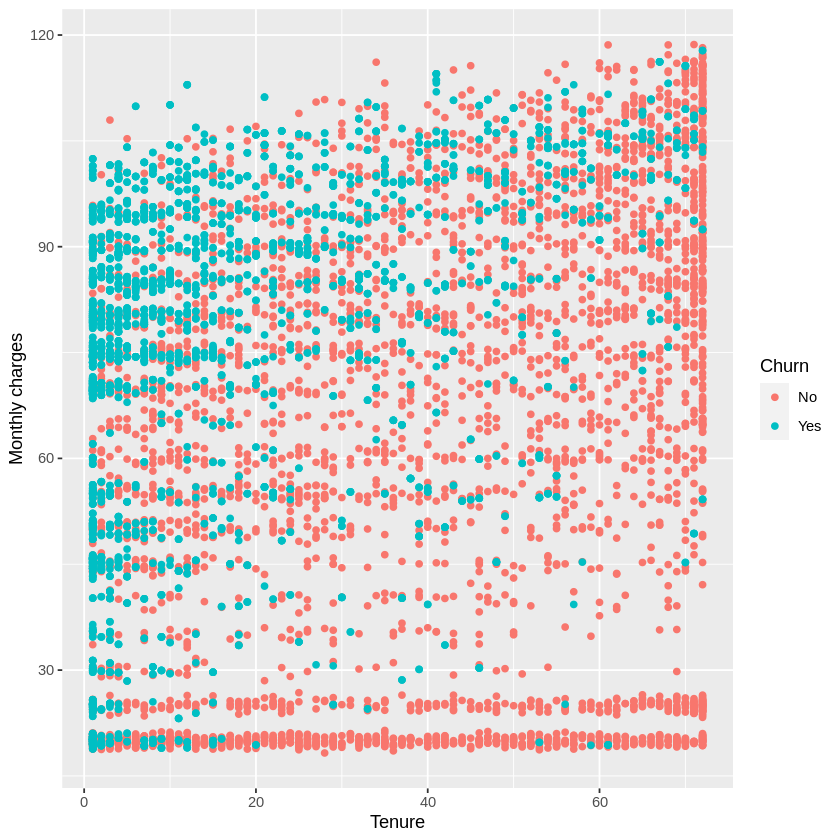

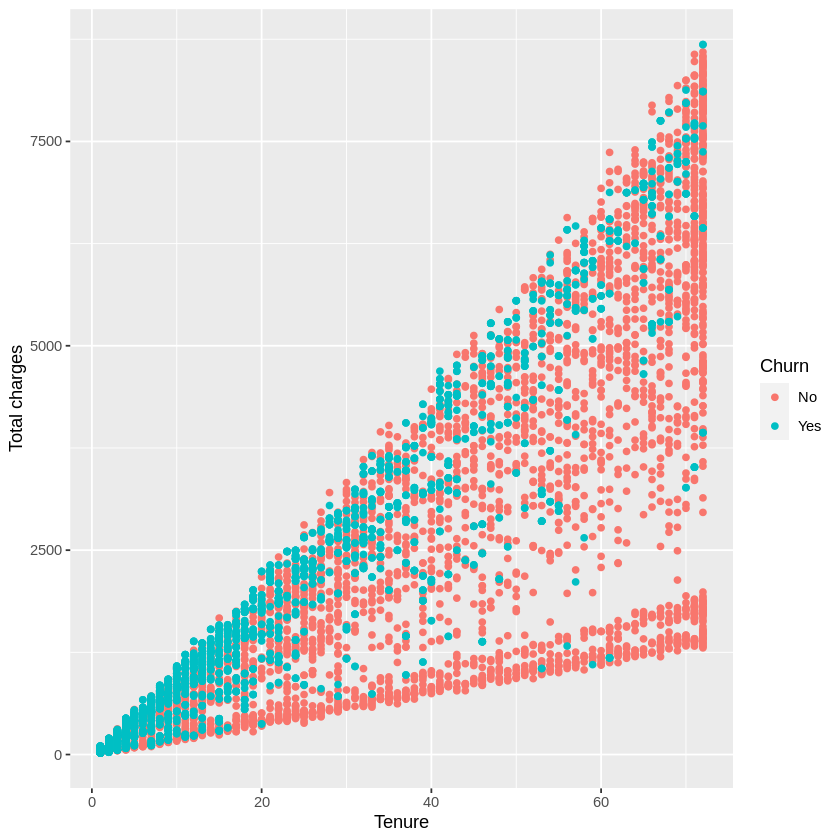

In [24]:
new_upsample_telecom_train_plot <- new_upsample_telecom_train |>
                                ggplot(aes(x=tenure, y = MonthlyCharges, color=Churn))+
                                geom_point()+
                                xlab("Tenure") +
                                ylab("Monthly charges")

new_upsample_telecom_train_plot 

new_upsample_telecom_train_plot2 <- new_upsample_telecom_train |>
                                ggplot(aes(x=tenure, y = TotalCharges, color=Churn))+
                                geom_point()+
                                xlab("Tenure") +
                                ylab("Total charges")
new_upsample_telecom_train_plot2



In [38]:
mean_tenure <- new_upsample_telecom_train |>    
               summarize(mean=mean(tenure))

mean_tenure

mean_monthly_charges <-  new_upsample_telecom_train |>    
                         summarize(mean=mean(MonthlyCharges))

mean_monthly_charges


mean_total_charges <-  new_upsample_telecom_train |>    
                         summarize(mean=mean(TotalCharges))

mean_total_charges



mean
<dbl>
27.87397


mean
<dbl>
68.24435


mean
<dbl>
2051.538


In [40]:
sd_tenure <- new_upsample_telecom_train |>    
               summarize(sd=sd(tenure))

sd_tenure

sd_monthly_charges <-  new_upsample_telecom_train |>    
                         summarize(sd=sd(MonthlyCharges))

sd_monthly_charges


sd_total_charges <-  new_upsample_telecom_train |>    
                         summarize(sd=sd(TotalCharges))

sd_total_charges



sd
<dbl>
24.08876


sd
<dbl>
28.73469


sd
<dbl>
2175.816


In [41]:
set.seed(1234)

knn_spec<-nearest_neighbor(weight_func="rectangular",neighbor=tune())|>
          set_engine("kknn")|>
          set_mode("classification")

telecom_recipe<-recipe(Churn~.,data=new_upsample_telecom_train)|>
                step_scale(all_predictors())|>
                step_center(all_predictors()) 

telecom_vfold<-vfold_cv(new_upsample_telecom_train,v=5,strata=Churn)



telecom_workflow<-workflow()|>
                  add_recipe(telecom_recipe)|>
                  add_model(knn_spec)|>
                  tune_grid(resamples=telecom_vfold,grid=10)|>
                  collect_metrics()


telecom_workflow

filtered_telecom_metrics<-telecom_workflow|>
                         filter(.metric=="accuracy")

filtered_telecom_metrics


print(filtered_telecom_metrics)

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.8536770,5,0.005511555,Preprocessor1_Model1
2,roc_auc,binary,0.8595921,5,0.005505026,Preprocessor1_Model1
3,accuracy,binary,0.7900847,5,0.004471605,Preprocessor1_Model2
⋮,⋮,⋮,⋮,⋮,⋮,⋮
13,roc_auc,binary,0.8326227,5,0.003899412,Preprocessor1_Model7
14,accuracy,binary,0.7544974,5,0.003434935,Preprocessor1_Model8
14,roc_auc,binary,0.8329972,5,0.003915938,Preprocessor1_Model8


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.8536770,5,0.005511555,Preprocessor1_Model1
3,accuracy,binary,0.7900847,5,0.004471605,Preprocessor1_Model2
5,accuracy,binary,0.7623345,5,0.006074726,Preprocessor1_Model3
⋮,⋮,⋮,⋮,⋮,⋮,⋮
12,accuracy,binary,0.7593763,5,0.003942363,Preprocessor1_Model6
13,accuracy,binary,0.7548830,5,0.003456548,Preprocessor1_Model7
14,accuracy,binary,0.7544974,5,0.003434935,Preprocessor1_Model8


# A tibble: 8 × 7
  neighbors .metric  .estimator  mean     n std_err .config             
      <int> <chr>    <chr>      <dbl> <int>   <dbl> <chr>               
1         2 accuracy binary     0.854     5 0.00551 Preprocessor1_Model1
2         3 accuracy binary     0.790     5 0.00447 Preprocessor1_Model2
3         5 accuracy binary     0.762     5 0.00607 Preprocessor1_Model3
4         7 accuracy binary     0.759     5 0.00610 Preprocessor1_Model4
5         9 accuracy binary     0.760     5 0.00417 Preprocessor1_Model5
6        12 accuracy binary     0.759     5 0.00394 Preprocessor1_Model6
7        13 accuracy binary     0.755     5 0.00346 Preprocessor1_Model7
8        14 accuracy binary     0.754     5 0.00343 Preprocessor1_Model8


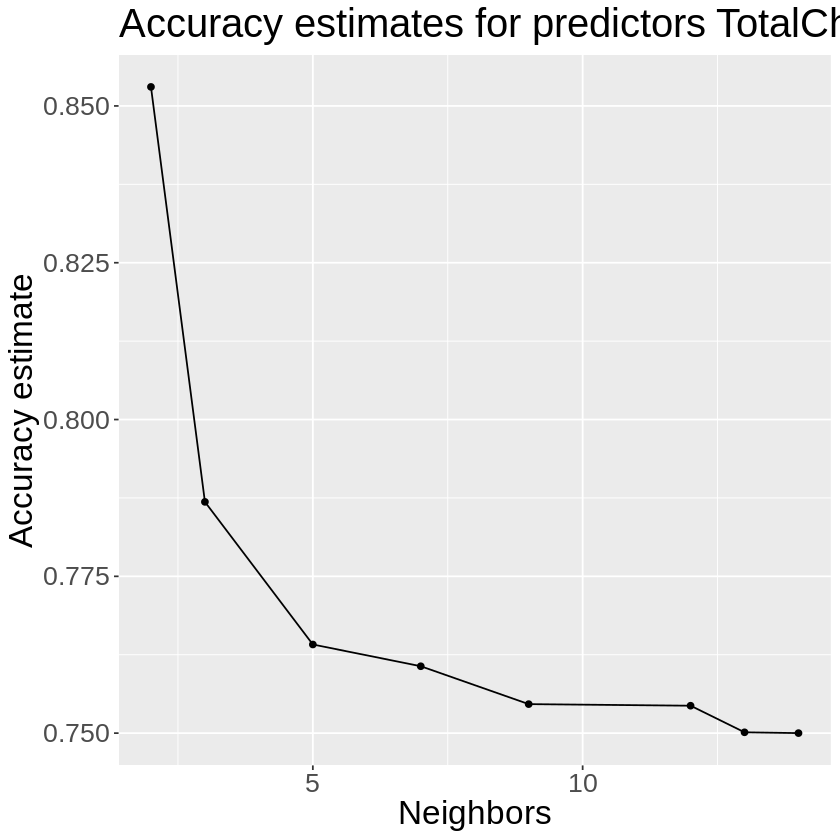

In [6]:
telecom_k_graph<-filtered_telecom_metrics|>
                 ggplot(aes(x=neighbors,y=mean))+
                 geom_point()+
                 geom_line()+
                 labs(x="Neighbors",y="Accuracy estimate")+
                 ggtitle("Accuracy estimates for predictors TotalCharges and tenure")+
                 theme(text=element_text(size=20))

telecom_k_graph

In [39]:
#Therefore, the ideal predictor is one where the k-value=2 

knn_spec_1<-nearest_neighbor(weight_func="rectangular",neighbor=2)|>
          set_engine("kknn")|>
          set_mode("classification")

telecom_workflow_1<-workflow()|>
                    add_recipe(telecom_recipe)|>
                    add_model(knn_spec_1)|>
                    fit(new_upsample_telecom_train)
                             
telecom_test_predictions<-predict(telecom_workflow_1,telecom_test)|>
                          bind_cols(telecom_test)
                             
telecom_test_metrics<-telecom_test_predictions|>
                       metrics(truth=Churn,estimate=.pred_class)|>
                       filter(.metric=="accuracy")
                             
telecom_test_conf_mat<-telecom_test_predictions|>
                       conf_mat(truth=Churn,estimate=.pred_class)
                             
telecom_test_metrics
telecom_test_conf_mat
                  

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7138794


          Truth
Prediction   No  Yes
       No  1033  265
       Yes  238  222